In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import pickle
import tensorflow as tf
import numpy as np
from behavioral_cloning import *
import matplotlib.pyplot as plt
import pandas as pd

## Inspect
show the shape of action and state

In [3]:
with open('./expert_data/Ant-v2.pkl', 'rb') as f:
    trace = pickle.load(f)
print('state shape {}'.format(trace['observations'].shape))
print('state example {}'.format(trace['observations'][0]))
print('actions shape {}'.format(trace['actions'].shape))
print('actions example {}'.format(trace['actions'][0]))

state shape (99286, 111)
state example [ 0.71573081  0.99940448  0.02172482  0.01214414 -0.02390038 -0.0665109
  0.01878657 -0.00400649  0.03484956  0.05231029  0.02381142 -0.04922052
  0.06561302  0.00577665 -0.16576287  0.0679862  -0.05062527  0.0702232
 -0.12525527 -0.03925672  0.00716105  0.04726429 -0.10090095 -0.05052721
  0.13599655  0.04025173 -0.04089372  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.     

# Behavioal Cloning
The following fits an FNN with one hidden layer of 50 nodes each for the task 'Hopper-v2' and 'Ant-v2'. Dropout of 0.5 is used on both stages. The number of expert rollouts for the imitation learning is 20. This is done for multiple different training epochs.

In [36]:
batch_size = 32
expert_rollout = 20
max_timesteps = 0 #0 means run until termination
use_expert_cache = True
store=False
losses = []



#tasks = ['Hopper-v2', 'Ant-v2', 'HalfCheetah-v2', 'Humanoid-v2', 'Reacher-v2','Walker2d-v2']
tasks = ['Hopper-v2','Ant-v2']
results = pd.DataFrame(columns=['Task','mean return','std return'])

for task in tasks:
    print("running task {}".format(task))
    tf.reset_default_graph()
    with tf.Session() as sess:
        epoch_count = 0
        repeats = [1,1,1,2,5,10,10,30]
        if use_expert_cache:
            original_dataset, expert_returns = get_dataset('./expert_data/{}-{}.pkl'.format(task,expert_rollout))
        else:
            original_dataset, expert_returns = get_dataset(envname=task,render=False,expert_policy_file='experts/'+task+'.pkl',max_timesteps=0,num_rollouts=expert_rollout,store=store)
        obs_dim = original_dataset.output_shapes[0].as_list()
        action_dim = original_dataset.output_shapes[1].as_list()[1:]
        behavioral_net = BehavioralCloningNet(obs_dim, action_dim, batch_size)
        sess.run(tf.global_variables_initializer())
        for repeat in repeats:
            epoch_count += repeat
            dataset = original_dataset.repeat(repeat)
            dataset = dataset.shuffle(10000)    
            batched_dataset = dataset.batch(batch_size)
            iterator = batched_dataset.make_one_shot_iterator()
            next_element = iterator.get_next()
            
            
            losses = behavioral_net.train(next_element)
            #behavioral_net, losses = train_behavioral_network(next_element, obs_dim, action_dim, batch_size)
            #subfig = plt.subplot()
            #fig = plt.figure()
            #plt.plot(losses)
            #plt.xlabel('Batch')
            #plt.ylabel('Loss (mean square)')
            #plt.legend(['Train loss {}'.format(task)],loc='upper center')
            #plt.show(fig)
            evaluate = Evaluate(task,render=False)
            evaluate.step = lambda obs: behavioral_net.predict([obs])
            returns = evaluate.evaluate(rollouts=expert_rollout)
            print("epoch count {}, mean return {}".format(epoch_count,np.mean(returns)))
            results = results.append({'Task': task,
                                'mean return': np.mean(returns),
                                'std return': np.std(returns),
                                'expert mean return': np.mean(expert_returns),
                                'expert std return': np.std(expert_returns),
                                'expert rollouts': expert_rollout,
                                'training epochs': epoch_count},
                                ignore_index=True)
results.to_csv('results_behavioral')

running task Hopper-v2
epoch count 1, mean return 86.01424279095141
epoch count 2, mean return 376.3243160248055
epoch count 3, mean return 347.8085061160989
epoch count 5, mean return 1614.5736073670391
epoch count 10, mean return 933.1737559997521
epoch count 20, mean return 1876.6829548454884
epoch count 30, mean return 1480.327540024101
epoch count 60, mean return 1089.0657311612567
running task Ant-v2
epoch count 1, mean return 842.6915291029618
epoch count 2, mean return 863.9644430962196
epoch count 3, mean return 1889.251554509469
epoch count 5, mean return 2716.23244975866
epoch count 10, mean return 4456.359134099143
epoch count 20, mean return 4743.4709501173975
epoch count 30, mean return 4800.326577434871
epoch count 60, mean return 4722.404918017156


In [37]:
results.drop('expert rollouts',axis=1)

,Task,mean return,std return,expert mean return,expert std return,training epochs
0,Hopper-v2,86.014243,1.216554,3777.774247,3.781346,1.0
1,Hopper-v2,376.324316,1.534914,3777.774247,3.781346,2.0
2,Hopper-v2,347.808506,5.934984,3777.774247,3.781346,3.0
3,Hopper-v2,1614.573607,223.622034,3777.774247,3.781346,5.0
4,Hopper-v2,933.173756,417.603026,3777.774247,3.781346,10.0
5,Hopper-v2,1876.682955,246.333341,3777.774247,3.781346,20.0
6,Hopper-v2,1480.327540,427.595742,3777.774247,3.781346,30.0
7,Hopper-v2,1089.065731,241.632402,3777.774247,3.781346,60.0
8,Ant-v2,842.691529,98.849835,4791.193292,156.043874,1.0
9,Ant-v2,863.964443,191.212148,4791.193292,156.043874,2.0


<IPython.core.display.Javascript object>


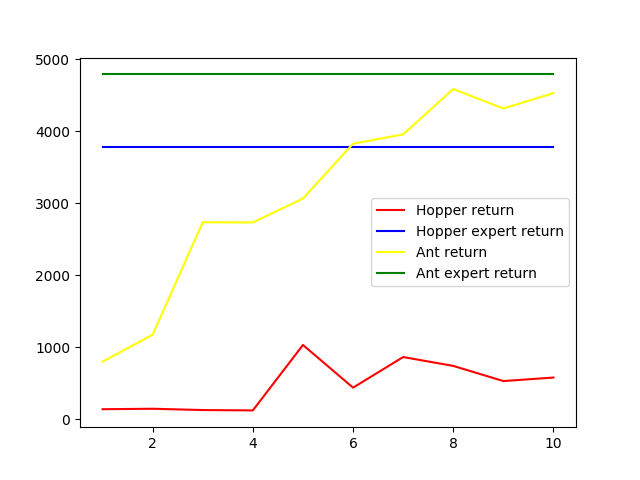

In [30]:
fig = plt.figure()
hopper_data = results[results['Task']=='Hopper-v2']
ant_data = results[results['Task']=='Ant-v2']
epochs = ant_data['training epochs'].values
plt.plot(epochs,hopper_data['mean return'].values,c='red')
plt.plot(epochs,hopper_data['expert mean return'].values,c='blue')
plt.plot(epochs,ant_data['mean return'].values,c='yellow')
plt.plot(epochs,ant_data['expert mean return'].values,c='green')
plt.legend(['Hopper return','Hopper expert return','Ant return','Ant expert return'])
plt.show(fig)